# Mixture Density Network (MDN)

The goal of this notebook is to test the implementation of Gaussian MDN in jax.

In [1]:
!echo $PYTHONPATH

:/local/home/sg276684/Documents/SBI/sbi_jax


In [1]:
%load_ext autoreload

%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import sbibm
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
from typing import Sequence, Callable, Any

import torch
import torch.utils.data as data

from jaxili.utils import create_data_loader
from jaxili.train import TrainerModule, TrainState

jax.config.update("jax_enable_x64", True)

from chainconsumer import ChainConsumer

2025-01-13 14:01:53.652577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Simulation model

In this notebook, we use the `sbibm` library API to demonstrate how our network architectures work. The user can freely change the task though not all of them are supported.

In [2]:
sbibm.get_available_tasks()

['gaussian_mixture',
 'bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'slcp',
 'two_moons',
 'sir',
 'lotka_volterra',
 'slcp_distractors',
 'bernoulli_glm_raw']

Let's first load a task, the corresponding prior and simulator and an observation and reference samples to assess the performance of our network.

In [3]:
task = sbibm.get_task('slcp')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]
dim_cond = observation.shape[1]
print(dim, dim_cond)

5 8


We then use the `torch.utils.data` to create datasets and embbed them in `DataLoader` structures from PyTorch. Those class should contain functions `__len__` and `__getitem__`. The function `create_data_loader` from `utils` then allows to build the data loaders with `jnp.ndarray` inside rather than `torch.Tensor`.

In [4]:
class SimulationDataset(data.Dataset):
    def __init__(self, num_points):
        super().__init__()
        self.thetas = prior(num_samples=num_points)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

In [5]:
train_set = SimulationDataset(20000)
val_set = SimulationDataset(2000)
test_set = SimulationDataset(5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size=128
)

## Neural posterior estimation using Gaussian MDN

In this notebook, we will use Gaussian Mixture Density Network to estimate the target density. The network can be imported from `normflow.model` and inherit from the class `NDENetwork` that requires method `log_prob` and `samples` to respectively compute the log probability and sample from the learned density.

In [6]:
from jaxili.model import MixtureDensityNetwork

In [7]:
NF_mdn = MixtureDensityNetwork(
    n_data=dim,
    n_components=3,
    layers=[128, 128],
    activation = jax.nn.silu
)

In [8]:
seed = jax.random.PRNGKey(0)
seed, init_seed = jax.random.split(seed)

params = NF_mdn.init(seed, jnp.zeros((1, dim_cond))) #Initialize the network

In [9]:
NF_mdn.apply(params, jnp.zeros((1, dim_cond)))

In [10]:
key = jax.random.PRNGKey(42)

batch_size = 54

thetas = prior(num_samples=batch_size)
xs = simulator(thetas)
thetas, xs = jnp.array(thetas), jnp.array(xs)

NF_mdn.apply(params, thetas, xs, method='log_prob') #To use other methods than the __call__
#the user should specify th ename of the method with the keyword 'method'.

Array([ -127.73284  ,  -188.65958  ,  -253.98506  ,   -57.063698 ,
        -261.5675   ,   -14.172913 ,  -270.592    ,   -90.205925 ,
         -13.506222 ,   -29.75908  ,   -16.430487 ,  -616.46124  ,
        -241.15756  ,   -17.612806 ,   -36.199684 ,   -92.96816  ,
         -16.336466 ,  -594.1446   ,   -43.26897  , -1437.4768   ,
        -255.02818  ,   -14.8891115,  -118.019    ,    -8.770114 ,
        -461.27744  ,   -19.497633 ,   -57.105556 ,    -7.7689395,
         -72.82124  , -3812.237    ,   -60.950756 ,  -160.10289  ,
        -350.31952  ,   -13.200145 ,    -8.3932705,  -123.67992  ,
        -193.27512  ,  -180.70804  ,   -52.50423  , -1316.7676   ,
         -59.634518 ,  -127.45038  ,  -275.6927   ,   -18.703403 ,
         -10.0561495,    -8.845956 ,   -13.51985  ,   -12.174928 ,
         -28.693447 ,   -24.76805  ,   -37.036034 ,  -109.72659  ,
         -11.870353 ,   -14.645933 ], dtype=float32)

In [16]:
key, subkey = jax.random.split(key)

samples = NF_mdn.apply(params, observation, num_samples=100, key=key, method='sample')

In [17]:
samples.shape
#Here we sampled 100 samples from the target posterior conditioned on the observation

(100, 5)

## Using TrainerModule to train the Mixture Density Network

We implemented a `TrainerModule` that manages everything concerning training from the initialisation of the network to saving the optimized weights.
The class implements a default way to perform the training with specific callbacks, saving methods, etc... The user can easily modify the default approach by inheriting from TrainerModule and modifying or creating methods in this new class.
We here show how one can use `TrainerModule` to train a Gaussian Mixture Density Network.

In [14]:
class MDNTrainer(TrainerModule):#Inherits from TrainerModule to use the training loop
    def __init__(self, #Overload __init__ with hyperparameters of the network
                 n_data : int,
                 n_components : int,
                 layers : Sequence[int],  
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=MixtureDensityNetwork,
                         model_hparams={
                            'n_data': n_data,
                            'n_components': n_components,
                            'layers': layers,
                            'activation': activation
                         },
                         **kwargs)
        self.trial = trial

    def create_functions(self): #The user has to create this function to initialize the train_step and test_step.
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step

    def print_tabulate(self, exmp_input):
         pass
        
    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()


In [21]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints/' #Specify the path where you save the results of the training

trainer = MDNTrainer(n_data=dim, #Create your trainer
                            n_components=4,
                            layers=[128, 128],
                            activation='silu',
                            optimizer_hparams={'lr': 5e-4},
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(train_loader))[1], #beware of the training input.
                            check_val_every_epoch=5
                            )

In [26]:
trainer.state.params

{'Dense_0': {'kernel': Array([[ 0.19735977, -0.2777632 ,  0.5395082 , ...,  0.29252547,
           0.6595205 ,  0.31818345],
         [-0.38413733,  0.3253297 , -0.0029012 , ...,  0.46761525,
          -0.25300848, -0.24535222],
         [-0.43881115, -0.19997755, -0.14933619, ..., -0.67584527,
           0.28703326,  0.14333649],
         ...,
         [ 0.6786783 , -0.30780813, -0.25470042, ...,  0.5837938 ,
          -0.251602  , -0.20748779],
         [ 0.1540942 ,  0.07870566,  0.20958132, ..., -0.08161764,
          -0.6372304 ,  0.5887578 ],
         [-0.26717114,  0.3099601 ,  0.7956528 , ..., -0.04616122,
           0.43892893,  0.1523408 ]], dtype=float32),
  'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

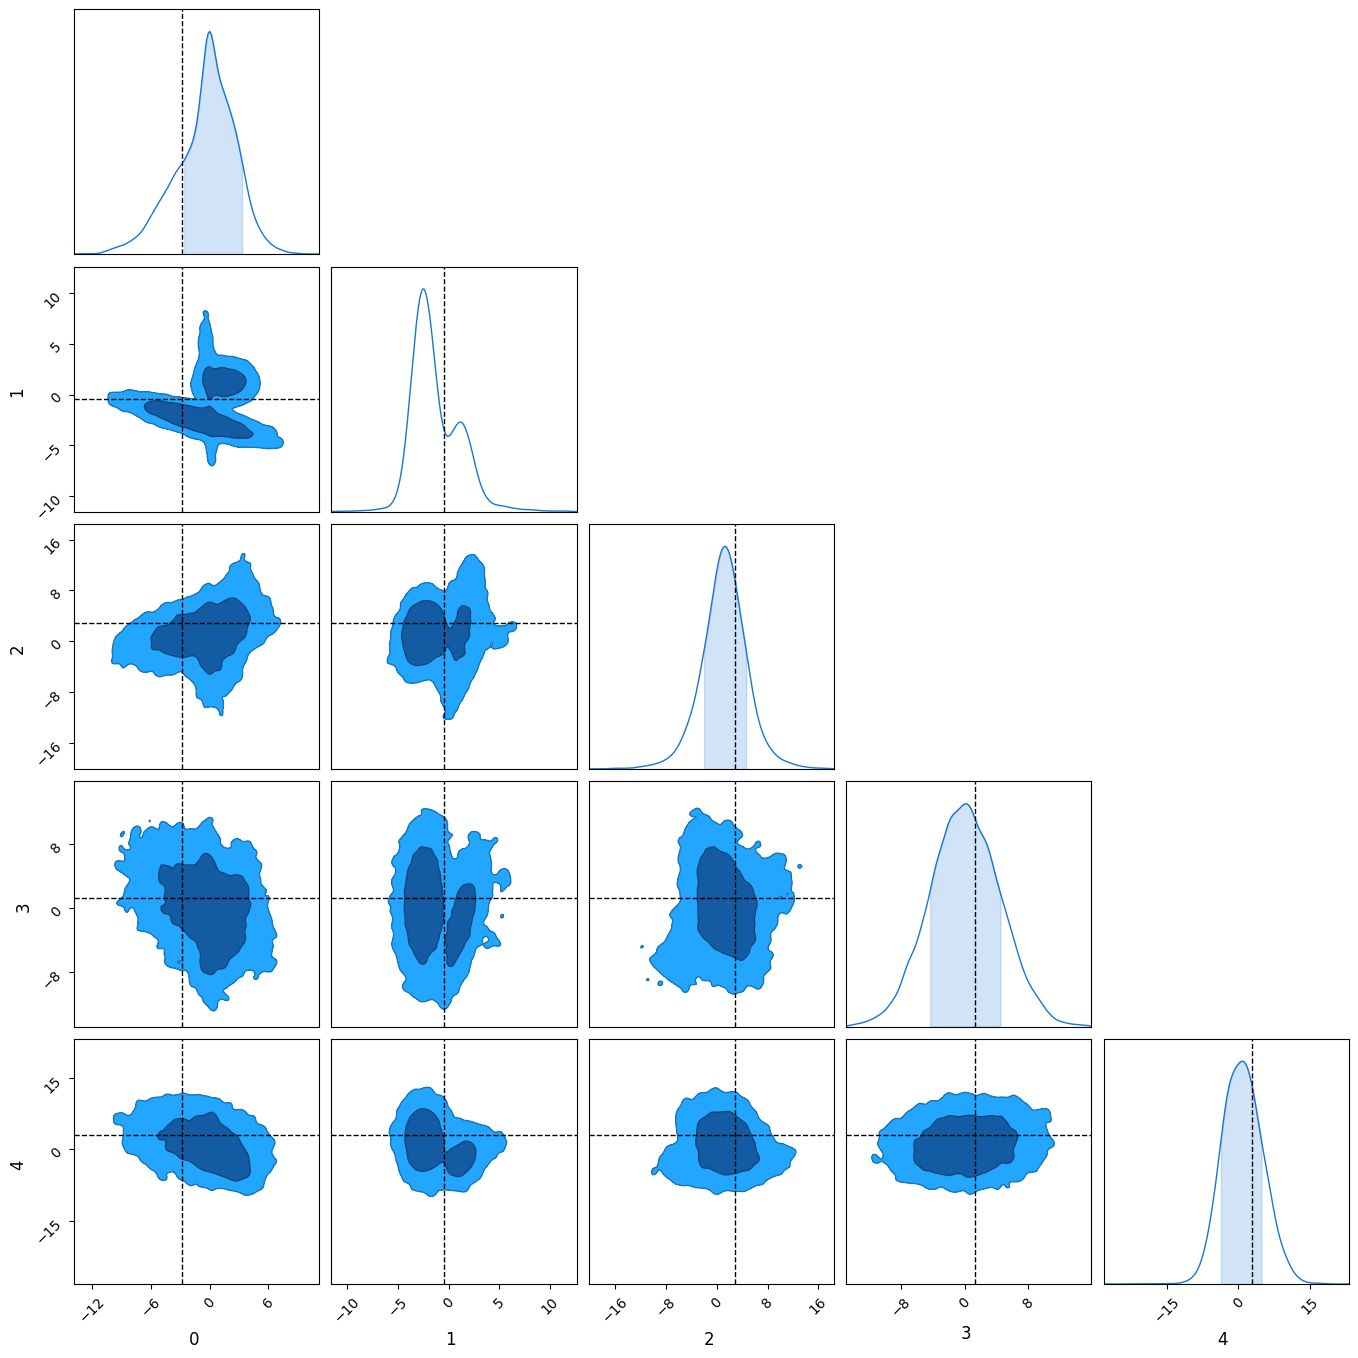

In [25]:
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(samples)
fig = c.plotter.plot(figsize=2., truth=np.array(truth))
plt.show()

In [16]:
metrics = trainer.train_model( #It is as simple as calling this function now.
    train_loader, val_loader, test_loader=test_loader, num_epochs=100
)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [17]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 6.517012119293213
Validation loss: 7.074177265167236
Test loss: 7.206582069396973


In [18]:
model = trainer.bind_model() #Freeze the network after training

In [19]:
key = jax.random.PRNGKey(42) #let's get our samples

samples = model.apply({'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample')

Let's compare to the true target density!

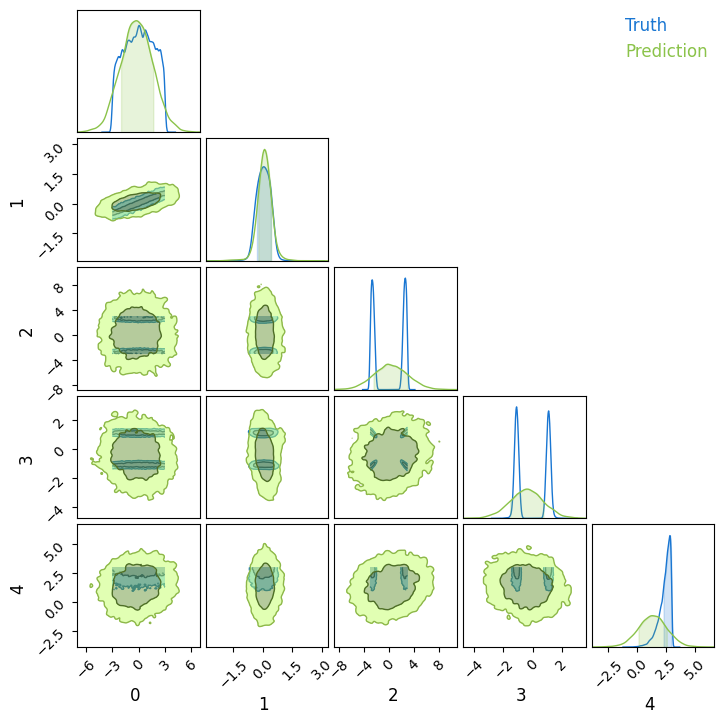

In [20]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

The posterior here is difficult to learn. It's highly non-linear with multimodality. By playing with the hyperparameters, it is possible to capture some of those features.

## Comparing training statistics with TensorBoard

The `TrainerModule` saved a file containing the statistics of training readable with TensorBoard which allows to check on the fly the evolution of the training. It is directly accessible from VSCode using the following command lines or by launching tensorboard directly using the command `Python: Launch Tensorboard` from VSCode.

In [26]:
%load_ext tensorboard
%tensorboard --logdir ~/work/jax/notebooks/checkpoints/

## Optimizing hyperparameter choice with Optuna

`optuna` is a Python library that allows to explore hyperparameter space and perform a grid search in hyperparameter space to find the best model satisfying some criteria. We will here test various models varying the number of Gaussian components and the learning rate of the optimizer.

In [14]:
import optuna

In [15]:
CHECKPOINT_PATH = '/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints'

In [19]:
def objective(trial):
    my_train_loader, my_val_loader = create_data_loader(train_set, val_set,
                                                         train=[True, False],
                                                         batch_size=256)
    trainer = MDNTrainer(n_data=dim, #Create your trainer
                            n_components=trial.suggest_int('n_components', 3, 10),
                            layers=[128, 128],
                            activation=jax.nn.silu,
                            optimizer_hparams={
                                  'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
                              },
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(my_train_loader))[1], #beware of the training input.
                            check_val_every_epoch=5,
                            enable_progress_bar=False,
                            trial=trial)
    metrics = trainer.train_model(my_train_loader,
                                  my_val_loader,
                                  num_epochs=200)
    del trainer
    del my_train_loader, my_val_loader
    return metrics['val/loss']

In [20]:
study = optuna.create_study(
    study_name='mdn_slcp_hparam_search',
    storage=f'sqlite:///{CHECKPOINT_PATH}/mdn_hparam_search.db',
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)
study.optimize(objective, n_trials=25-len(study.trials), n_jobs=1)

[I 2024-02-15 14:23:53,060] Using an existing study with name 'mdn_slcp_hparam_search' instead of creating a new one.


In [21]:
trial = study.best_trial
print(f'Best Loss: {trial.value:.2f}')
print(f'Best hyperparameters:')
for key, value in trial.params.items():
    print(f' ->   {key}: {value}')

Best Loss: 5.84
Best hyperparameters:
 ->   n_components: 10
 ->   lr: 0.005899158256597192


In [18]:
trainer = MDNTrainer.load_from_checkpoints(os.path.join(CHECKPOINT_PATH, 'MixtureDensityNetwork/version_21/'),
                                               exmp_input=next(iter(train_loader))[1])
test_metrics = trainer.eval_model(test_loader)
print(f'Test accuracy: {test_metrics["loss"]:.2f}')

Test accuracy: 5.72


In [23]:
fig = optuna.visualization.plot_contour(study, params=['lr', 'n_components'])
fig.show()

In [19]:
model = trainer.bind_model()

In [20]:
key = jax.random.PRNGKey(42) #let's get our samples

samples = model.apply({'params': trainer.state.params}, observation, num_samples=10000, key=key, method='sample')

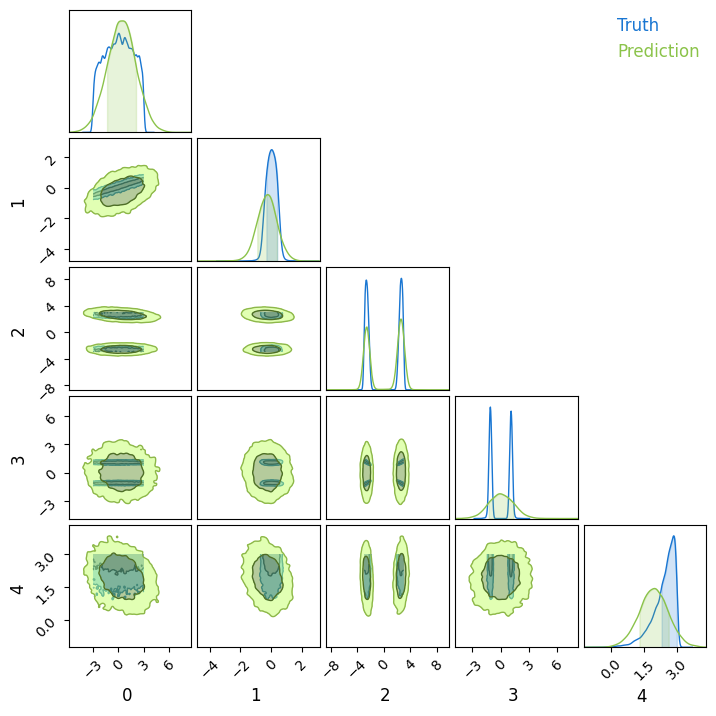

In [21]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

We see that the best model was here able to capture part of the multimoality of the posterior.

We highlight that in this notebook we stuck to Posterior Density Estimation. This use case is called Simple Likelihood Complex Posterior. It could thus make sense to perform Likelihood Density Estimation and sample from the learned likelihood to capture the complexity of the posterior.